# Setup environment

## Install Open FUSION Toolkit and add to path
To load the TokaMaker python module we need to tell python where to the module is located. This can be done either through the `PYTHONPATH` environment variable or using within a script using `sys.path.append()` as below, where we look for the environement variable `OFT_ROOTPATH` to provide the path to where the OpenFUSIONToolkit is installed (`/Applications/OFT` on macOS).

In [1]:
import os
import sys
try:
    from google.colab import output
    output.enable_custom_widget_manager()
except:
    tokamaker_python_path = os.getenv('OFT_ROOTPATH')
    if tokamaker_python_path is not None:
        sys.path.append(os.path.join(tokamaker_python_path,'python'))
    %matplotlib inline
    pass
else:
    !pip install triangle wurlitzer ipympl
    OFT_package = 'OpenFUSIONToolkit_v1.0.0-beta4-Linux-GNU-x86_64'
    OFT_tarball = 'OpenFUSIONToolkit_v1.0.0-beta4-Ubuntu_20_04-GNU-x86_64.tar.gz'
    if not os.path.exists(os.path.join('/content',OFT_package,'python')):
        !wget https://github.com/hansec/OpenFUSIONToolkit/releases/download/v1.0.0-beta4/{OFT_tarball}
        !tar xzf {OFT_tarball}
        !wget https://raw.githubusercontent.com/hansec/OpenFUSIONToolkit/main/src/examples/TokaMaker/ITER/ITER_mesh.h5
    OFT_rootpath = os.path.join('/content',OFT_package)
    sys.path.append(os.path.join(OFT_rootpath,'python'))
    %load_ext wurlitzer
    %matplotlib ipympl

## Load other Python packages



In [2]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize']=(6,6)
plt.rcParams['font.weight']='bold'
plt.rcParams['axes.labelweight']='bold'
plt.rcParams['lines.linewidth']=2
plt.rcParams['lines.markeredgewidth']=2

# Computing equilbria with a known boundary

## Load TokaMaker objects from OFT
For meshing we will use the \ref OpenFUSIONToolkit.TokaMaker.gs_Domain "gs_Domain" class to build a 2D triangular grid suitable for Grad-Shafranov equilibria. This class uses the [triangle code](https://www.cs.cmu.edu/~quake/triangle.html) through a [python wrapper](https://pypi.org/project/triangle/).

In [3]:
from OpenFUSIONToolkit.TokaMaker import TokaMaker
from OpenFUSIONToolkit.TokaMaker.meshing import load_gs_mesh
from OpenFUSIONToolkit.TokaMaker.util import create_isoflux

## Compute equilibria

### Initialize TokaMaker object
First we create a TokaMaker instance to use for equilibrium calculations. Note at present only a single instance can be used per python kernel, so this command should only be called **once** in a given Jupyter notebook or python script. In the future this restriction may be relaxed.

In [4]:
mygs = TokaMaker()

#----------------------------------------------
Open FUSION Toolkit Initialized
Development branch:   tMaker_power_flux_fun
Revision id:          e06699b
Parallelization Info:
  # of MPI tasks      =    1
  # of NUMA nodes     =    1
  # of OpenMP threads =    2
Fortran input file    = oftpyin                                                                         
XML input file        = none                                                                            
Integer Precisions    =    4   8
Float Precisions      =    4   8  16
Complex Precisions    =    4   8
LA backend            = native
#----------------------------------------------



### Load mesh into TokaMaker
Now we load the mesh generated in \ref doc_tMaker_ITER_ex1 using \ref OpenFUSIONToolkit.TokaMaker.load_gs_mesh "load_gs_mesh()" and \ref OpenFUSIONToolkit.TokaMaker.TokaMaker.setup_mesh "setup_mesh". Then we use \ref OpenFUSIONToolkit.TokaMaker.TokaMaker.setup_regions "setup_regions()", passing the conductor and coil dictionaries for the mesh, to define the different region types. Finally, we call \ref OpenFUSIONToolkit.TokaMaker.TokaMaker.setup "setup()" to setup the required solver objects. During this call we can specify the desired element order (min=2, max=4) and the toroidal field through F0 = B0*R0, where B0 is the toroidal field at a reference location R0.

In [5]:
mesh_pts,mesh_lc,mesh_reg,coil_dict,cond_dict = load_gs_mesh('ITER_mesh.h5')
mygs.setup_mesh(mesh_pts, mesh_lc, mesh_reg)
mygs.setup_regions(cond_dict=cond_dict,coil_dict=coil_dict)
mygs.setup(order = 2, F0 = 5.3*6.2)


**** Generating surface grid level  1
  Generating boundary domain linkage
  Mesh statistics:
    Area         =  2.859E+02
    # of points  =    4757
    # of edges   =   14156
    # of cells   =    9400
    # of boundary points =     112
    # of boundary edges  =     112
    # of boundary cells  =     112
  Resolution statistics:
    hmin =  9.924E-03
    hrms =  2.827E-01
    hmax =  8.466E-01
  Surface grounded at vertex     870


**** Creating Lagrange FE space
  Order  =    2
  Minlev =   -1

 Computing flux BC matrix 
 Inverting real matrix
   Time =    9.1500000000000001E-004


## Plot mesh
**Need to add mesh plotting to main **

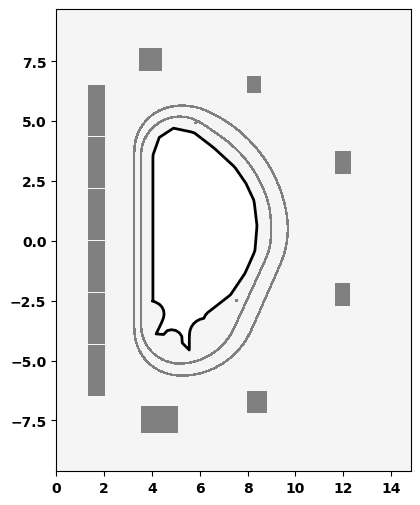

In [6]:
fig, ax = plt.subplots(1,1)
mygs.plot_machine(fig,ax)

### Define hard limits on coil currents
Hard limits on coil currents can be set using \ref OpenFUSIONToolkit.TokaMaker.TokaMaker.set_coil_bounds "set_coil_bounds()". In this case we just the simple and approximate bi-directional limit of 50 MA in each coil.

Note that the size of the bounds array is (ncoils+1,2) as bounds can also be set for the VSC set, which is treated as a separate degree of freedom (virtual coil) if defined.

In [7]:
coil_bounds = np.zeros((mygs.ncoils+1,2), dtype=np.float64)
coil_bounds[:,0] = -50.E6; coil_bounds[:,1] = 50.E6
mygs.set_coil_bounds(coil_bounds)

### Define coil regularization matrix
In general, for a given coil set a given plasma shape cannot be exactly reproduced, which generally yields large amplitude coil currents if no constraint on the coil currents is applied. As a result, it is useful to include regularization terms for the coils to balance minimization of the shape error with the amplitude of current in the free coils. In TokaMaker these regularization terms have the general form of a vector of targets (often zero), a regularization matrix that maps the coil currents to the targets, and a vector of weights that can be used to control the relative impact of each term in the minimization.

Here we use the identity as the regularization matrix, with zero for all targets and modest weights on the CS and PF coils. This regularization acts to penalize the amplitude of current in each coil, acting to balance coil current with error in the shape targets. Note that the weight on the VSC virtual coil defined above is set high to prevent interaction with the real `VS` coil set (see below for further information).

In [8]:
coil_reg_mat = np.eye(mygs.ncoils+1, dtype=np.float64)
coil_reg_weights = 1.E-2*np.ones((mygs.ncoils+1,))
coil_reg_targets = np.zeros((mygs.ncoils+1,))

# Pass regularization terms to TokaMaker
mygs.set_coil_reg(coil_reg_mat, reg_weights=coil_reg_weights, reg_targets=coil_reg_targets)

## Compute Inverse Equilibrium

### Define global quantities and targets
For the inverse case we define a target for the plasma current and the peak plasma pressure, which occurs on the magnetic axis.

**Note:** These constraints can be considered "hard" constraints, where they will be matched to good tolerance as long as the calculation converges.

In [9]:
Ip_target=15.6E6
P0_target=6.2E5
mygs.set_targets(Ip=Ip_target, pax=P0_target)

### Define shape targets
In order to constrain the shape of the plasma we can utilize two types of constraints:
 1. `isoflux` points, which are points we want to lie on the same flux surface (eg. the LCFS)
 2. `saddle` points, where we want the poloidal magnetic field to vanish (eg. X-points). While one can also use this constraint to enforce a magnetic axis location, instead \ref OpenFUSIONToolkit.TokaMaker.TokaMaker.set_targets "set_targets()" should be used with arguments `R0` and `V0`.

**Note:** These constraints can be considered "soft" constraints, where the calculation attempts to minimize error in satisfying these constraints subject to other constraints and regularization.

Here we define a handful of isoflux points that we want to lie on the LCFS of the target equilibrium. Additionally, we define a single X-point and set it as a saddle constraint as well as adding it to the list of isoflux points.

In [10]:
nTargets = 20
R0_target = 6.3
Z0_target = 0.5
a_target = 2.0
kappa_target = 1.0
delta_target = 0.0
LCFS_contour = create_isoflux(nTargets,R0_target,Z0_target,a_target,kappa_target,delta_target)
mygs.set_isoflux(LCFS_contour)

### Define flux functions
Although TokaMaker has a "default" profile for the F\*F' and P' terms this should almost never be used and one should instead choose an appropriate flux function for their application. In this case we use an L-mode-like profile of the form $((1-\hat{\psi})^{\alpha})^{\gamma}$, where $\alpha$ and $\gamma$ are set differently for F\*F' and P' to provide peaked and broad profiles respectively. Within TokaMaker this profile is represented as a piecewise linear function, which can be set up using the dictionary approach shown below.

**Note:** More tools to aide in setting these profiles are coming soon

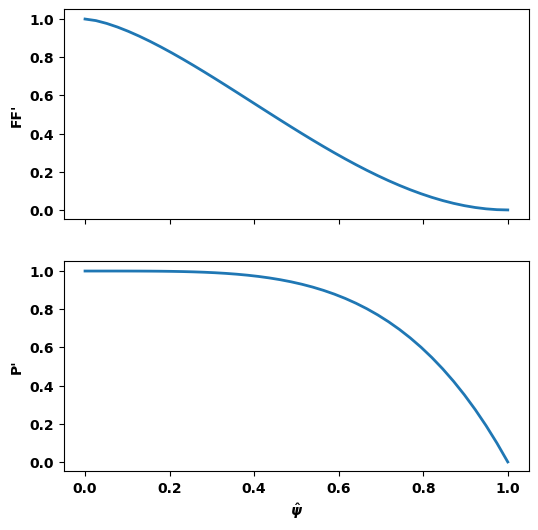

In [11]:
n_sample = 40
psi_sample = np.linspace(0.0,1.0,n_sample)

# Set F*F' profile
alpha = 1.5
gamma = 2.0
ffp_prof = {
    'type': 'linterp',
    'x': psi_sample,
    'y': np.power(1.0-np.power(psi_sample,alpha),gamma)
}
ffp_prof['y'] /= ffp_prof['y'][0] # Normalize profile (not required but convienient)

# Set P' profile
alpha = 4.0
gamma = 1.0
pp_prof = {
    'type': 'linterp',
    'x': psi_sample,
    'y': np.power(1.0-np.power(psi_sample,alpha),gamma)
}
pp_prof['y'] /= pp_prof['y'][0] # Normalize profile (not required but convienient)

fig, ax = plt.subplots(2,1,sharex=True)
# Plot F*F'
ax[0].plot(ffp_prof['x'],ffp_prof['y'])
ax[0].set_ylabel("FF'")
# Plot P'
ax[1].plot(pp_prof['x'],pp_prof['y'])
ax[1].set_ylabel("P'")
_ = ax[-1].set_xlabel(r"$\hat{\psi}$")

mygs.set_profiles(ffp_prof=ffp_prof,pp_prof=pp_prof)

### Compute equilibrium
We can now compute a free-boundary equilibrium using these constraints. Note that before running a calculation for the first time we must initialize the flux function $\psi$, which can be done using \ref OpenFUSIONToolkit.TokaMaker.TokaMaker.init_psi "init_psi()". This subroutine initializes the flux using the specified Ip_target from above, which is evenly distributed over the entire plasma region or only with a boundary defined using a center point (R,Z), minor radius (a), and elongation and triangularity. Coil currents are also initialized at this point using the constraints above and this uniform plasma current initialization. 

\ref OpenFUSIONToolkit.TokaMaker.TokaMaker.solve "solve()" is then called to compute a self-consitent Grad-Shafranov equilibrium. If the result variable (`err_flag`) is zero then the solution has converged to the desired tolerance ($10^{-6}$ by default).

In [12]:
err_flag = mygs.init_psi(R0_target,Z0_target,a_target,kappa_target,delta_target)
err_flag = mygs.solve()

Starting non-linear GS solver
     1  1.3522E+01  1.8981E-01  3.6593E-01  6.5661E+00  4.9995E-01 -3.9504E-11
     2  3.1796E+01  8.2234E-02  7.9349E-02  6.5147E+00  5.0002E-01 -1.6554E-12
     3  3.6984E+01  6.5602E-02  2.3106E-02  6.4906E+00  5.0003E-01  4.4458E-12
     4  3.9131E+01  6.0662E-02  9.9106E-03  6.4785E+00  5.0004E-01 -7.7604E-12
     5  4.0091E+01  5.8836E-02  4.8550E-03  6.4722E+00  5.0004E-01 -7.6396E-12
     6  4.0531E+01  5.8087E-02  2.4245E-03  6.4689E+00  5.0004E-01  9.6620E-12
     7  4.0732E+01  5.7763E-02  1.2177E-03  6.4673E+00  5.0016E-01 -5.4987E-12
     8  4.0825E+01  5.7619E-02  6.1609E-04  6.4663E+00  5.0015E-01  8.3178E-12
     9  4.0868E+01  5.7554E-02  3.1449E-04  6.4658E+00  5.0015E-01 -9.6222E-12
    10  4.0888E+01  5.7525E-02  1.6196E-04  6.4655E+00  5.0014E-01 -1.3365E-12
    11  4.0897E+01  5.7512E-02  8.4072E-05  6.4654E+00  5.0014E-01 -7.5469E-12
    12  4.0901E+01  5.7506E-02  4.3928E-05  6.4653E+00  5.0014E-01  4.1878E-12
    13  4.0903E+01  5.

### Plot equilibrium
Flux surfaces of the computed equilibrium can be plotted using the \ref OpenFUSIONToolkit.TokaMaker.TokaMaker.plot_psi "plot_psi()" method. The additional plotting methods \ref OpenFUSIONToolkit.TokaMaker.TokaMaker.plot_machine "plot_machine()" and \ref OpenFUSIONToolkit.TokaMaker.TokaMaker.plot_constraints "plot_constraints()" are also used to show context and other information. Each method has a large number of optional arguments for formatting and other options.

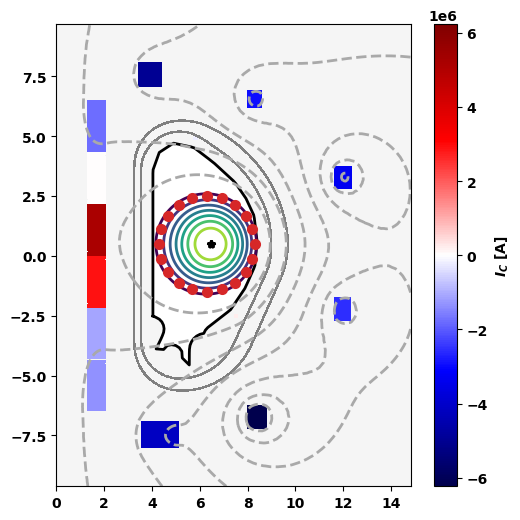

In [13]:
fig, ax = plt.subplots(1,1)
mygs.plot_machine(fig,ax,coil_colormap='seismic',coil_symmap=True)
mygs.plot_psi(fig,ax)
mygs.plot_constraints(fig,ax,isoflux_marker='o')

## Helper fucntion for plotting

In [14]:
def formatted_plot(gs_obj,title):
    fig, ax = plt.subplots(1,1)
    ax.set_title(title)
    gs_obj.plot_machine(fig,ax,coil_colormap='seismic',coil_symmap=True,coil_scale=1.E-6,coil_clabel=r'$I_C$ [MA]')
    gs_obj.plot_psi(fig,ax,xpoint_color=None,vacuum_nlevels=4)
    gs_obj.plot_constraints(fig,ax,isoflux_color='tab:red',isoflux_marker='o')

## Turn off iteration reporting for scans

In [15]:
mygs.settings.pm=False
mygs.update_settings()

## Scan elongation

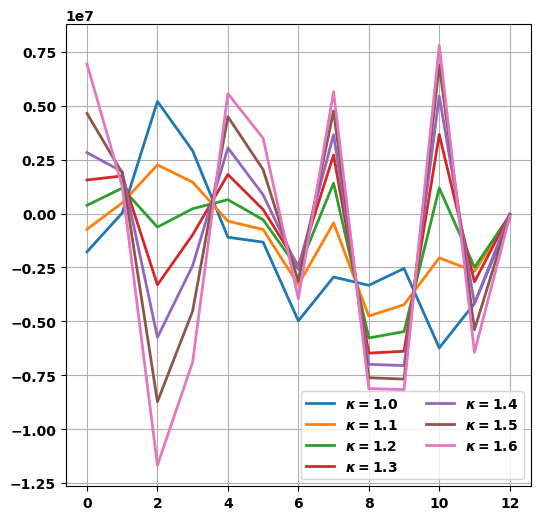

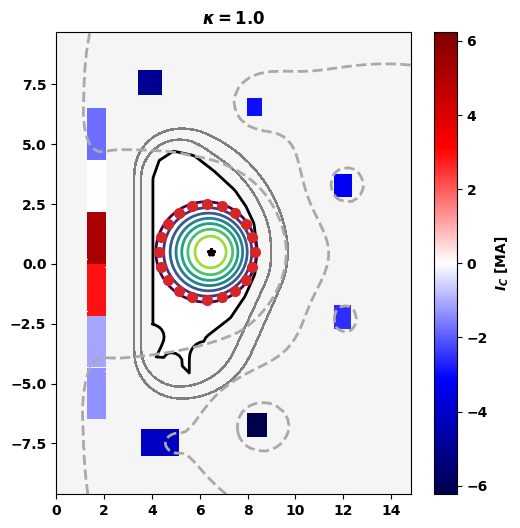

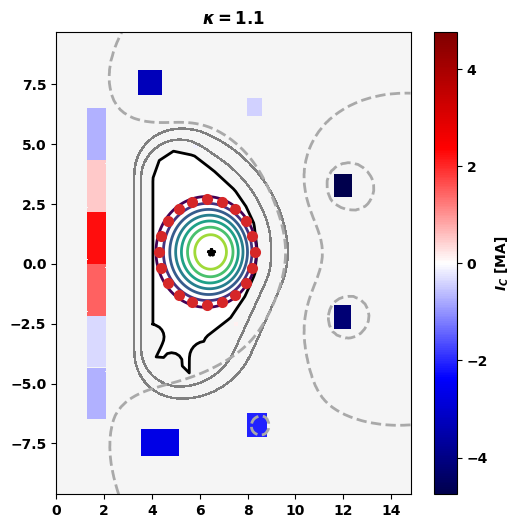

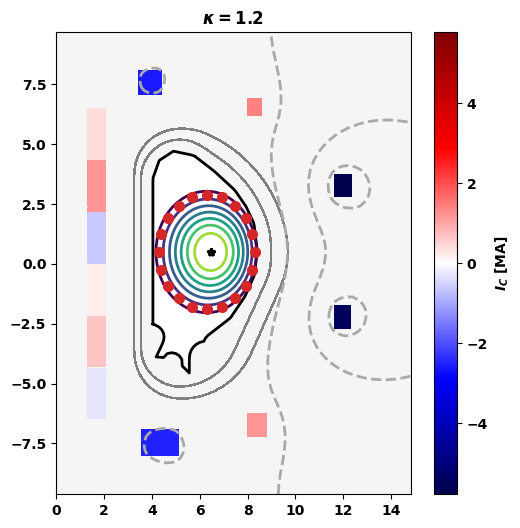

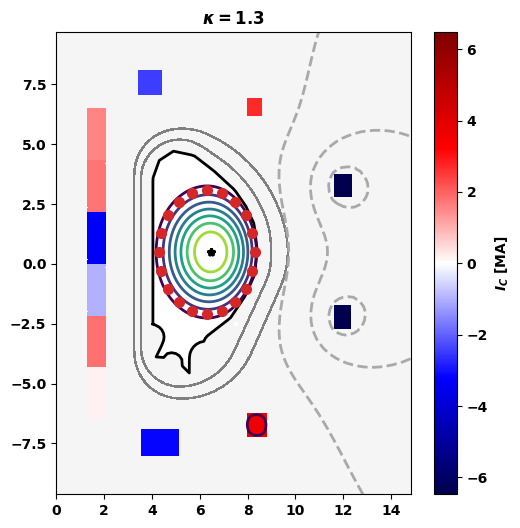

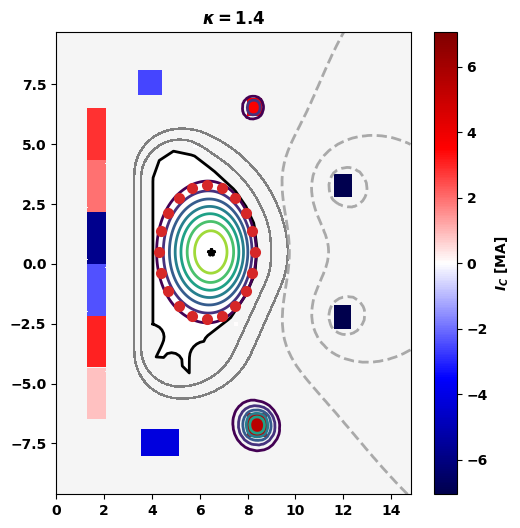

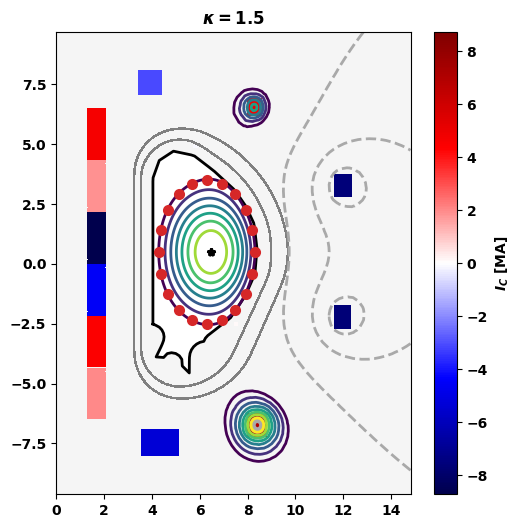

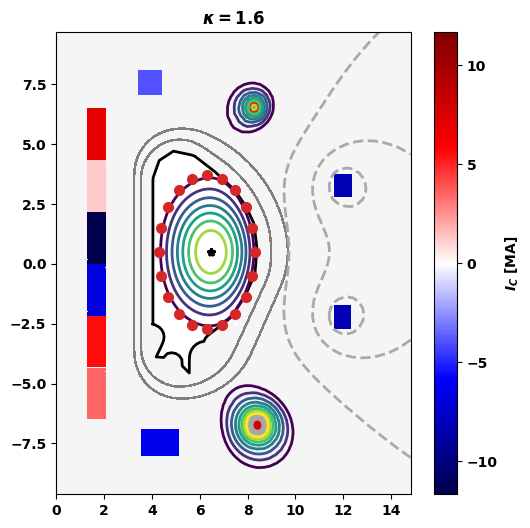

In [18]:
curr_fig, curr_ax = plt.subplots(1,1)
for kappa_target_tmp in np.linspace(1.0,1.6,7):
    # Set new target for kappa
    LCFS_contour = create_isoflux(nTargets,R0_target,Z0_target,a_target,kappa_target_tmp,delta_target)
    mygs.set_isoflux(LCFS_contour)
    # Resolve
    err_flag = mygs.solve()
    # Plot coil currents
    currents, _ = mygs.get_coil_currents()
    curr_ax.plot(currents,label=r'$\kappa = {0:.1f}$'.format(kappa_target_tmp))
    # Plot
    formatted_plot(mygs,r'$\kappa = {0:.1f}$'.format(kappa_target_tmp))
curr_ax.grid(True)
curr_ax.legend(ncols=2)

## Scan triangularity

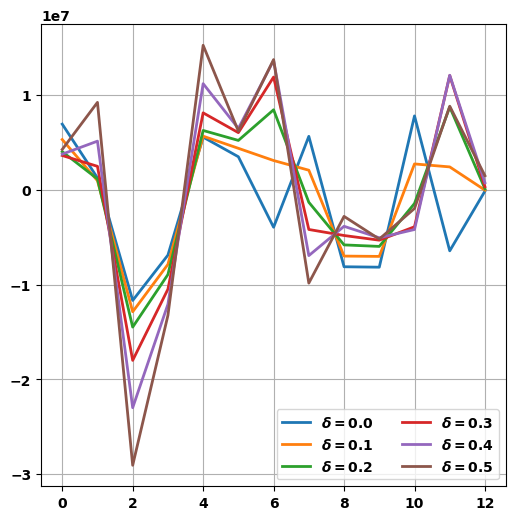

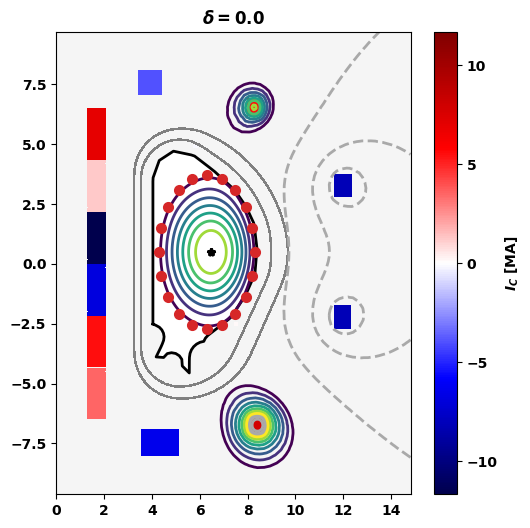

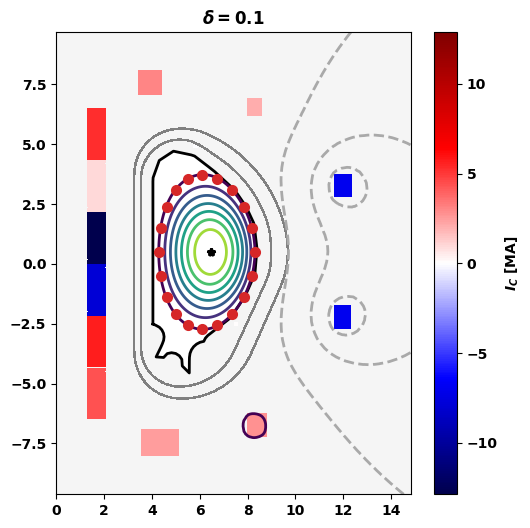

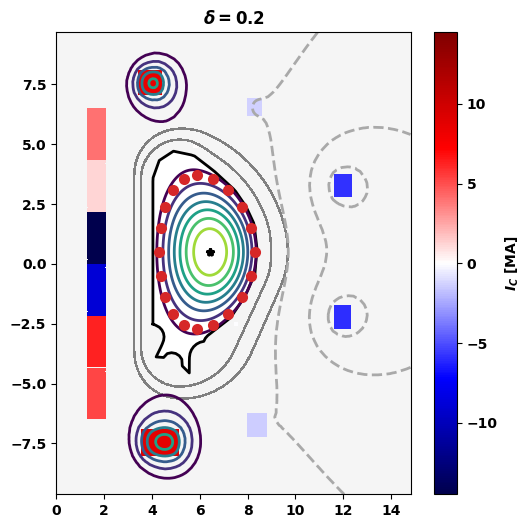

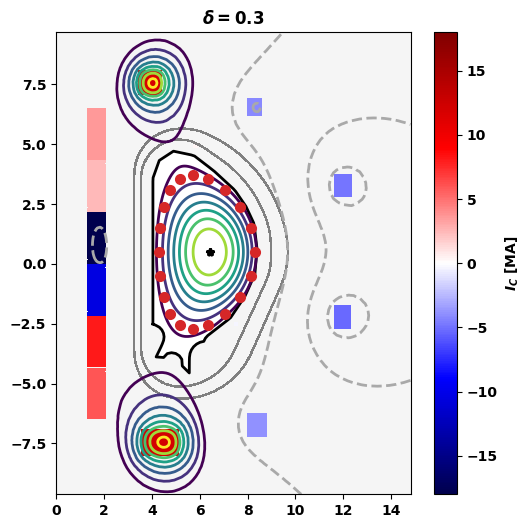

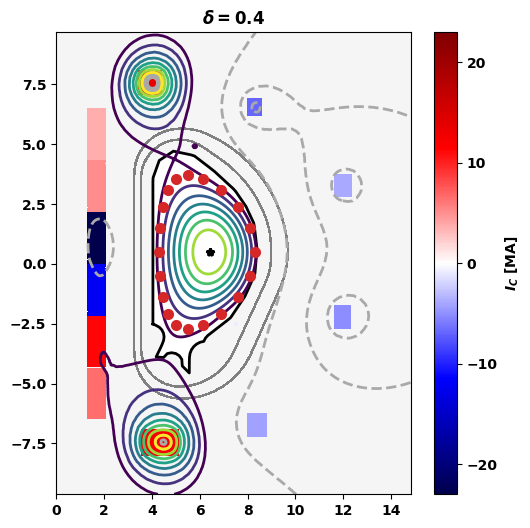

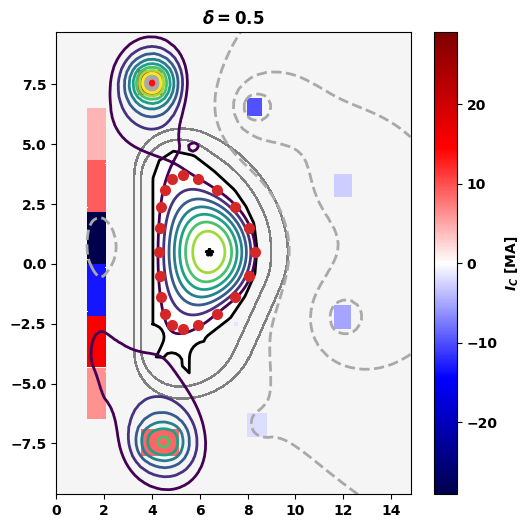

In [19]:
kappa_target = 1.6
curr_fig, curr_ax = plt.subplots(1,1)
for delta_target_tmp in np.linspace(0.0,0.5,6):
    # Set new target for delta
    LCFS_contour = create_isoflux(nTargets,R0_target,Z0_target,a_target,kappa_target,delta_target_tmp)
    mygs.set_isoflux(LCFS_contour)
    # Resolve
    err_flag = mygs.solve()
    # Plot coil currents
    currents, _ = mygs.get_coil_currents()
    curr_ax.plot(currents,label=r'$\delta = {0:.1f}$'.format(delta_target_tmp))
    # Plot
    formatted_plot(mygs,r'$\delta = {0:.1f}$'.format(delta_target_tmp))
curr_ax.grid(True)
curr_ax.legend(ncols=2)

## Change the parameters yourself

 * What is the highest stored energy you can get?
 * What is the higher plasma current you can get?
 * What does the safety factor ($q$) look like as we adjust the shape?
 * Where can you place the X-point and strike points?